In [1]:
from fastai.vision import *

In [2]:
path = untar_data(URLs.MNIST)
data = (ImageItemList.from_folder(path/'training')
                     .random_split_by_pct()
                     .label_from_folder()
                     .databunch())

In [3]:
class Model(nn.Module):
    def __init__(self, classifier, size=(28,28)):
        super().__init__()
        self.localization = nn.Sequential(
            conv_layer(3, 32, stride=2),
            conv_layer(32, 64, stride=2),
            conv_layer(64, 128, stride=2),
            AdaptiveConcatPool2d(),
            Flatten(), *bn_drop_lin(256, 6)
        )
        self.size = size
        self.sampling_grid = self._build_grid().cuda()
        self.classifier = classifier
    
    def _build_grid(self):
        H,W = self.size
        x = torch.linspace(-1, 1, W)
        y = torch.linspace(-1, 1, H)
        x_t, y_t = [e.contiguous().view(-1) for e in torch.meshgrid(x,y)]
        return torch.stack([x_t, y_t, torch.ones_like(x_t)])[None]
    
    def stn(self, x):
        H,W = self.size
        bs = x.size(0)
        theta = self.localization(x).view(-1,2,3)
        # build grid
        sampling_grid = self.sampling_grid.repeat(bs,1,1)
        grid = theta @ sampling_grid
        grid = grid.view(-1, 2, W, H).permute(0,3,2,1)
        x = F.grid_sample(x, grid)
        return x
        
    def forward(self, x):
        x = self.stn(x)
        return self.classifier(x)

In [4]:
tmp = create_cnn(data, models.resnet18, metrics=accuracy)
m = Model(tmp.model)
learn = Learner(data, m, metrics=accuracy, path='tmp')

In [5]:
l = learn.model.localization[-1]
w = l.weight
b = l.bias
identity = torch.cat([torch.eye(2), torch.zeros(2,1)], dim=1).view(-1)
with torch.no_grad():
    w.fill_(0.)
    b.data = identity.cuda()

In [6]:
x,y = data.one_batch(denorm=False, cpu=False)
with torch.no_grad():
    x_ = learn.model.stn(x)

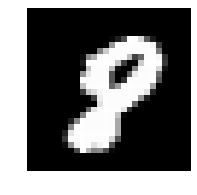

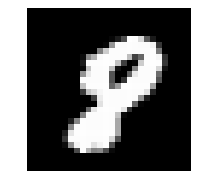

In [7]:
i = np.random.choice(64)
data.x.reconstruct(x[i]).show()
data.x.reconstruct(x_[i]).show()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


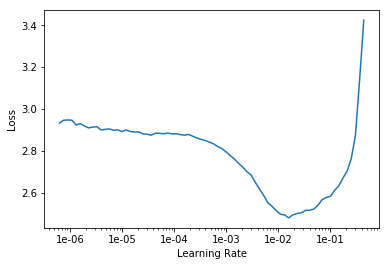

In [8]:
learn.lr_find()
learn.recorder.plot()

In [8]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy
1,0.563057,0.423464,0.863917
2,0.299155,0.235655,0.928000
3,0.213889,0.121565,0.960750
4,0.128075,0.084819,0.972500
5,0.123617,0.073156,0.977083


In [9]:
# learn.save('2d')
# learn.load('2d');

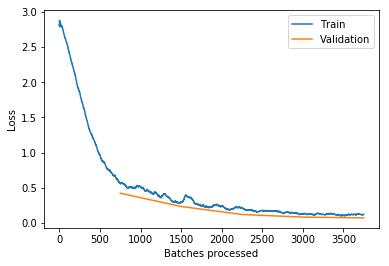

In [10]:
learn.recorder.plot_losses()

In [11]:
x,y = data.one_batch(denorm=False, cpu=False)
with torch.no_grad():
    theta = learn.model.localization(x).view(-1,2,3)
    x_ = learn.model.stn(x)
    y_ = learn.model.classifier(x_).argmax(1)

In [12]:
W,H = 28,28
x,y = data.one_batch(DatasetType.Valid, denorm=False, cpu=False)
with torch.no_grad():
    theta = learn.model.localization(x).view(-1,2,3)
    sampling_grid = learn.model.sampling_grid.repeat(64,1,1)
    grid = theta @ sampling_grid
    grid = grid.view(-1, 2, W, H).permute(0,3,2,1)
    x_ = F.grid_sample(x, grid)
    y_ = learn.model.classifier(x_).argmax(1)

True: 8, Pred: 8


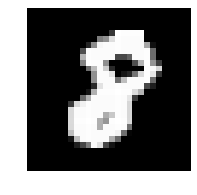

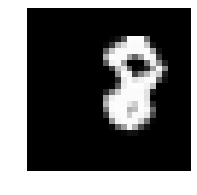

In [13]:
i = np.random.choice(64)
print(f'True: {y[i].item()}, Pred: {y_[i].item()}')
data.x.reconstruct(x[i]).show()
data.x.reconstruct(x_[i]).show()

In [14]:
def tfm(x,theta):
    return F.grid_sample(x[None], (theta @ learn.model.sampling_grid[0]).view(2,28,28).permute(2,1,0)[None])[0]

def show_tfm(x,theta):
    data.x.reconstruct(tfm(x,theta)).show()

In [15]:
theta[i]

tensor([[ 1.3706, -0.2826, -0.3908],
        [-0.0067,  1.2362,  0.0866]], device='cuda:0')

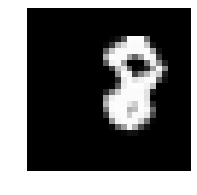

In [16]:
show_tfm(x[i], theta[i])

In [17]:
x,y = data.one_batch(DatasetType.Valid, denorm=False, cpu=False)

with torch.no_grad():
    theta = learn.model.localization(x).view(-1,2,3)
    sampling_grid = learn.model.sampling_grid.repeat(64,1,1)
    grid = theta @ sampling_grid
    grid = grid.view(-1, 2, W, H).permute(0,3,2,1)
    x_s = grid[..., 0]
    y_s = grid[..., 1]
    xx = ((x_s + 1.) * W) * 0.5
    yy = ((y_s + 1.) * H) * 0.5
    x_ = F.grid_sample(x, grid)
    y_ = learn.model.classifier(x_).argmax(1)

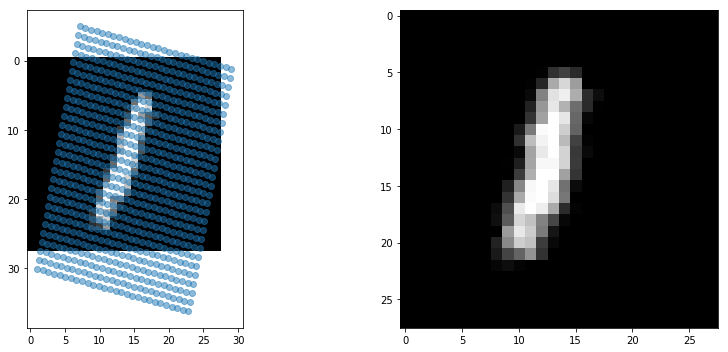

In [28]:
idx = np.random.choice(64)
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(13,5))
ax1.imshow(x[idx,0], 'gray')
points = torch.stack([xx[idx], yy[idx]], dim=-1).view(-1,2)
ax1.scatter(points[:,0], points[:,1], alpha=0.5)
ax2.imshow(x_[idx,0], 'gray')
plt.tight_layout()

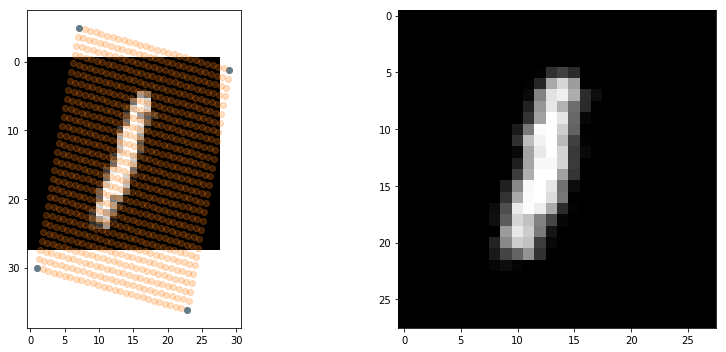

In [29]:
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(13,5))
ax1.imshow(x[idx,0], 'gray')
t = [0,27,-28,-1]
ax1.scatter(points[t,0], points[t,1], alpha=0.95)
ax1.scatter(points[:,0], points[:,1], alpha=0.25)
ax2.imshow(x_[idx,0], 'gray')
plt.tight_layout()

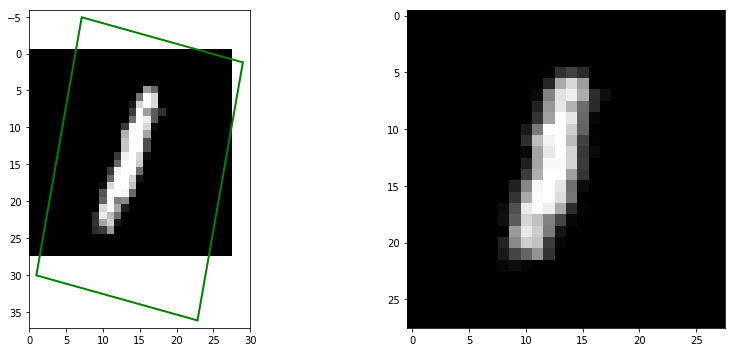

In [30]:
idx = np.random.choice(64)
print(f'True: {y[idx].item()}, Pred: {y_[idx].item()}')
fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(13,5))
ax1.imshow(x[idx,0], 'gray')
t = [0,27,-1,-28]
points = torch.stack([xx[idx], yy[idx]], dim=-1).view(-1,2)
x0,x1 = min(0, points[:,0].min()-1), max(W, points[:,0].max()+1)
y1,y0 = min(0, points[:,1].min()-1), max(H, points[:,1].max()+1)
ax1.set_xlim(x0,x1)
ax1.set_ylim(y0,y1)
ax1.add_patch(patches.Polygon(points[t], fill=False, edgecolor='green', lw=2))
ax2.imshow(x_[idx,0], 'gray')
for ax in (ax1,ax2): ax.set_axis_off()
plt.tight_layout()